In [7]:
#|export
import torch
import pickle
import numpy as np
from torchvision import transforms
# from multiprocessing.pool import ThreadPool
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
from PIL import Image
from fastbook import *
from fastai.vision.widgets import *
import mmcv
import numpy as np

In [8]:
model = pickle.load(open('/home/anna/MFTI/yoga_pose_detection/simpcon_class_model.pkl', 'rb')).eval()

In [9]:
# Copyright (c) OpenMMLab. All rights reserved.

def palette_val(palette):
    """Convert palette to matplotlib palette.

    Args:
        palette List[tuple]: A list of color tuples.

    Returns:
        List[tuple[float]]: A list of RGB matplotlib color tuples.
    """
    new_palette = []
    for color in palette:
        color = [c / 255 for c in color]
        new_palette.append(tuple(color))
    return new_palette


def get_palette(palette, num_classes):
    """Get palette from various inputs.

    Args:
        palette (list[tuple] | str | tuple | :obj:`Color`): palette inputs.
        num_classes (int): the number of classes.

    Returns:
        list[tuple[int]]: A list of color tuples.
    """
    assert isinstance(num_classes, int)

    if isinstance(palette, list):
        dataset_palette = palette
    elif isinstance(palette, tuple):
        dataset_palette = [palette] * num_classes
    elif palette == 'random' or palette is None:
        state = np.random.get_state()
        # random color
        np.random.seed(42)
        palette = np.random.randint(0, 256, size=(num_classes, 3))
        np.random.set_state(state)
        dataset_palette = [tuple(c) for c in palette]
    elif palette == 'coco':
        from mmdet.datasets import CocoDataset, CocoPanopticDataset
        dataset_palette = CocoDataset.PALETTE
        if len(dataset_palette) < num_classes:
            dataset_palette = CocoPanopticDataset.PALETTE
    elif palette == 'citys':
        from mmdet.datasets import CityscapesDataset
        dataset_palette = CityscapesDataset.PALETTE
    elif palette == 'voc':
        from mmdet.datasets import VOCDataset
        dataset_palette = VOCDataset.PALETTE
    elif mmcv.is_str(palette):
        dataset_palette = [mmcv.color_val(palette)[::-1]] * num_classes
    else:
        raise TypeError(f'Invalid type for palette: {type(palette)}')

    assert len(dataset_palette) >= num_classes, \
        'The length of palette should not be less than `num_classes`.'
    return dataset_palette

In [10]:
# Copyright (c) OpenMMLab. All rights reserved.
import sys
from PIL import Image
import PIL
import cv2
import matplotlib.pyplot as plt
import mmcv
import pickle
import numpy as np
import torch
import torch.nn as nn
import pycocotools.mask as mask_util
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from torchvision import transforms

from mmdet.core.evaluation.panoptic_utils import INSTANCE_OFFSET
# from ..mask.structures import bitmap_to_polygon

# from ..utils import mask2ndarray
# from .palette import get_palette, palette_val

__all__ = [
    'color_val_matplotlib', 'draw_masks', 'draw_bboxes', 'draw_labels',
    'imshow_det_bboxes', 'imshow_gt_det_bboxes'
]

EPS = 1e-2


def color_val_matplotlib(color):
    """Convert various input in BGR order to normalized RGB matplotlib color
    tuples.

    Args:
        color (:obj`Color` | str | tuple | int | ndarray): Color inputs.

    Returns:
        tuple[float]: A tuple of 3 normalized floats indicating RGB channels.
    """
    color = mmcv.color_val(color)
    color = [color / 255 for color in color[::-1]]
    return tuple(color)


def _get_adaptive_scales(areas, min_area=800, max_area=30000):
    """Get adaptive scales according to areas.

    The scale range is [0.5, 1.0]. When the area is less than
    ``'min_area'``, the scale is 0.5 while the area is larger than
    ``'max_area'``, the scale is 1.0.

    Args:
        areas (ndarray): The areas of bboxes or masks with the
            shape of (n, ).
        min_area (int): Lower bound areas for adaptive scales.
            Default: 800.
        max_area (int): Upper bound areas for adaptive scales.
            Default: 30000.

    Returns:
        ndarray: The adaotive scales with the shape of (n, ).
    """
    scales = 0.5 + (areas - min_area) / (max_area - min_area)
    scales = np.clip(scales, 0.5, 1.0)
    return scales


def _get_bias_color(base, max_dist=30):
    """Get different colors for each masks.

    Get different colors for each masks by adding a bias
    color to the base category color.
    Args:
        base (ndarray): The base category color with the shape
            of (3, ).
        max_dist (int): The max distance of bias. Default: 30.

    Returns:
        ndarray: The new color for a mask with the shape of (3, ).
    """
    new_color = base + np.random.randint(
        low=-max_dist, high=max_dist + 1, size=3)
    return np.clip(new_color, 0, 255, new_color)


def draw_bboxes(ax, bboxes, color='g', alpha=0.8, thickness=2):
    """Draw bounding boxes on the axes.

    Args:
        ax (matplotlib.Axes): The input axes.
        bboxes (ndarray): The input bounding boxes with the shape
            of (n, 4).
        color (list[tuple] | matplotlib.color): the colors for each
            bounding boxes.
        alpha (float): Transparency of bounding boxes. Default: 0.8.
        thickness (int): Thickness of lines. Default: 2.

    Returns:
        matplotlib.Axes: The result axes.
    """
    polygons = []
    for i, bbox in enumerate(bboxes):
        bbox_int = bbox.astype(np.int32)
        poly = [[bbox_int[0], bbox_int[1]], [bbox_int[0], bbox_int[3]],
                [bbox_int[2], bbox_int[3]], [bbox_int[2], bbox_int[1]]]
        np_poly = np.array(poly).reshape((4, 2))
        polygons.append(Polygon(np_poly))
    p = PatchCollection(
        polygons,
        facecolor='none',
        edgecolors=color,
        linewidths=thickness,
        alpha=alpha)
    ax.add_collection(p)

    return ax


def draw_labels(ax,
                labels,
                positions,
                scores=None,
                yoga = None,
                class_names=None,
                color='w',
                font_size=6,
                scales=None,
                horizontal_alignment='left'):
    """Draw labels on the axes.

    Args:
        ax (matplotlib.Axes): The input axes.
        labels (ndarray): The labels with the shape of (n, ).
        positions (ndarray): The positions to draw each labels.
        scores (ndarray): The scores for each labels.
        class_names (list[str]): The class names.
        color (list[tuple] | matplotlib.color): The colors for labels.
        font_size (int): Font size of texts. Default: 8.
        scales (list[float]): Scales of texts. Default: None.
        horizontal_alignment (str): The horizontal alignment method of
            texts. Default: 'left'.

    Returns:
        matplotlib.Axes: The result axes.
    """
    print(999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999)
    for i, (pos, label, yoga_label) in enumerate(zip(positions, labels, yoga)):
        if class_names is not None:
            if label == 0 and yoga_label is not None:
                label_text = 'yoga '+ class_names[label] + '\n' + 'pose is '+ yoga_label
            elif label == 0 and yoga_label is None:
                label_text = 'not yoga '+ class_names[label]
        else:
            if yoga is not None:
                f'class {label} {yoga}'
            else:
                f'class {label}'
        
        #label_text = class_names[
         #   label] if class_names is not None else f'class {label}'
        if scores is not None:
            label_text += f'|{scores[i]:.02f}'
        text_color = color[i] if isinstance(color, list) else color

        font_size_mask = font_size if scales is None else font_size * scales[i]
        ax.text(
            pos[0],
            pos[1],
            f'{label_text}',
            bbox={
                'facecolor': 'black',
                'alpha': 0.8,
                'pad': 0.7,
                'edgecolor': 'none'
            },
            color=text_color,
            fontsize=font_size_mask,
            verticalalignment='top',
            horizontalalignment=horizontal_alignment)

    return ax


def draw_masks(ax, img, masks, color=None, with_edge=True, alpha=0.8):
    """Draw masks on the image and their edges on the axes.

    Args:
        ax (matplotlib.Axes): The input axes.
        img (ndarray): The image with the shape of (3, h, w).
        masks (ndarray): The masks with the shape of (n, h, w).
        color (ndarray): The colors for each masks with the shape
            of (n, 3).
        with_edge (bool): Whether to draw edges. Default: True.
        alpha (float): Transparency of bounding boxes. Default: 0.8.

    Returns:
        matplotlib.Axes: The result axes.
        ndarray: The result image.
    """
    taken_colors = set([0, 0, 0])
    if color is None:
        random_colors = np.random.randint(0, 255, (masks.size(0), 3))
        color = [tuple(c) for c in random_colors]
        color = np.array(color, dtype=np.uint8)
    polygons = []
    for i, mask in enumerate(masks):
        if with_edge:
            contours, _ = bitmap_to_polygon(mask)
            polygons += [Polygon(c) for c in contours]

        color_mask = color[i]
        while tuple(color_mask) in taken_colors:
            color_mask = _get_bias_color(color_mask)
        taken_colors.add(tuple(color_mask))

        mask = mask.astype(bool)
        img[mask] = img[mask] * (1 - alpha) + color_mask * alpha

    p = PatchCollection(
        polygons, facecolor='none', edgecolors='w', linewidths=1, alpha=0.8)
    ax.add_collection(p)

    return ax, img
    
    
#my predict fubction for yoga classification
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs
    
effnet_b0_yoga = pickle.load(open('/home/anna/Загрузки/yoga_poses_classificator_model.pkl', 'rb'))

def classify_yoga_pose(img):

    image = img
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
    w, h = image.size
    if h>w:
        image = transforms.functional.pad(image, padding = [round(abs(h-w)/2), 0])
    else:
        image = transforms.functional.pad(image, padding = [0, round(abs(h-w)/2)])
    image = image.resize((224, 224))
    x = np.array(image)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    x = x.unsqueeze(0)   
    s = predict(effnet_b0_yoga, [x])
    if max(s[0]) < 0.65:
        return None
    else:
        y_pred = np.argmax(s,-1)

        return  yoga_class_labels[int(y_pred)]

#yoga_labels
yoga_class_labels = ['adho mukha svanasana', 'adho mukha vriksasana', 'agnistambhasana',
       'ananda balasana', 'anantasana', 'anjaneyasana', 'ardha bhekasana',
       'ardha chandrasana', 'ardha matsyendrasana',
       'ardha pincha mayurasana', 'ardha uttanasana',
       'ashtanga namaskara', 'astavakrasana', 'baddha konasana',
       'bakasana', 'balasana', 'bhairavasana', 'bharadvajasana i',
       'bhekasana', 'bhujangasana', 'bhujapidasana', 'bitilasana',
       'camatkarasana', 'chakravakasana', 'chaturanga dandasana',
       'dandasana', 'dhanurasana', 'durvasasana',
       'dwi pada viparita dandasana', 'eka pada koundinyanasana i',
       'eka pada koundinyanasana ii', 'eka pada rajakapotasana',
       'eka pada rajakapotasana ii', 'ganda bherundasana',
       'garbha pindasana', 'garudasana', 'gomukhasana', 'halasana',
       'hanumanasana', 'janu sirsasana', 'kapotasana', 'krounchasana',
       'kurmasana', 'lolasana', 'makara adho mukha svanasana',
       'makarasana', 'malasana', 'marichyasana i', 'marichyasana iii',
       'marjaryasana', 'matsyasana', 'mayurasana', 'natarajasana',
       'padangusthasana', 'padmasana', 'parighasana',
       'paripurna navasana', 'parivrtta janu sirsasana',
       'parivrtta parsvakonasana', 'parivrtta trikonasana',
       'parsva bakasana', 'parsvottanasana', 'pasasana',
       'paschimottanasana', 'phalakasana', 'pincha mayurasana',
       'prasarita padottanasana', 'purvottanasana', 'salabhasana',
       'salamba bhujangasana', 'salamba sarvangasana',
       'salamba sirsasana', 'savasana', 'setu bandha sarvangasana',
       'simhasana', 'sukhasana', 'supta baddha konasana',
       'supta matsyendrasana', 'supta padangusthasana', 'supta virasana',
       'tadasana', 'tittibhasana', 'tolasana', 'tulasana',
       'upavistha konasana', 'urdhva dhanurasana', 'urdhva hastasana',
       'urdhva mukha svanasana', 'urdhva prasarita eka padasana',
       'ustrasana', 'utkatasana', 'uttana shishosana', 'uttanasana',
       'utthita ashwa sanchalanasana', 'utthita hasta padangustasana',
       'utthita parsvakonasana', 'utthita trikonasana', 'vajrasana',
       'vasisthasana', 'viparita karani', 'virabhadrasana i',
       'virabhadrasana ii', 'virabhadrasana iii', 'virasana',
       'vriksasana', 'vrischikasana', 'yoganidrasana']


def imshow_det_bboxes(img,
                      bboxes=None,
                      labels=None,
                      segms=None,
                      class_names=None,
                      score_thr=0,
                      bbox_color='green',
                      text_color='green',
                      mask_color=None,
                      thickness=2,
                      font_size=8,
                      win_name='',
                      show=True,
                      wait_time=0,
                      out_file=None):
    """Draw bboxes and class labels (with scores) on an image.

    Args:
        img (str | ndarray): The image to be displayed.
        bboxes (ndarray): Bounding boxes (with scores), shaped (n, 4) or
            (n, 5).
        labels (ndarray): Labels of bboxes.
        segms (ndarray | None): Masks, shaped (n,h,w) or None.
        class_names (list[str]): Names of each classes.
        score_thr (float): Minimum score of bboxes to be shown. Default: 0.
        bbox_color (list[tuple] | tuple | str | None): Colors of bbox lines.
           If a single color is given, it will be applied to all classes.
           The tuple of color should be in RGB order. Default: 'green'.
        text_color (list[tuple] | tuple | str | None): Colors of texts.
           If a single color is given, it will be applied to all classes.
           The tuple of color should be in RGB order. Default: 'green'.
        mask_color (list[tuple] | tuple | str | None, optional): Colors of
           masks. If a single color is given, it will be applied to all
           classes. The tuple of color should be in RGB order.
           Default: None.
        thickness (int): Thickness of lines. Default: 2.
        font_size (int): Font size of texts. Default: 13.
        show (bool): Whether to show the image. Default: True.
        win_name (str): The window name. Default: ''.
        wait_time (float): Value of waitKey param. Default: 0.
        out_file (str, optional): The filename to write the image.
            Default: None.

    Returns:
        ndarray: The image with bboxes drawn on it.
    """
    assert bboxes is None or bboxes.ndim == 2, \
        f' bboxes ndim should be 2, but its ndim is {bboxes.ndim}.'
    assert labels.ndim == 1, \
        f' labels ndim should be 1, but its ndim is {labels.ndim}.'
    assert bboxes is None or bboxes.shape[1] == 4 or bboxes.shape[1] == 5, \
        f' bboxes.shape[1] should be 4 or 5, but its {bboxes.shape[1]}.'
    assert bboxes is None or bboxes.shape[0] <= labels.shape[0], \
        'labels.shape[0] should not be less than bboxes.shape[0].'
    assert segms is None or segms.shape[0] == labels.shape[0], \
        'segms.shape[0] and labels.shape[0] should have the same length.'
    assert segms is not None or bboxes is not None, \
        'segms and bboxes should not be None at the same time.'

    img = mmcv.imread(img).astype(np.uint8)

    if score_thr > 0:
        assert bboxes is not None and bboxes.shape[1] == 5
        scores = bboxes[:, -1]
        inds = scores > score_thr
        bboxes = bboxes[inds, :]
        labels = labels[inds]
        #print(labels)
        yoga_labels = []
        print(000000000000000000000000000000000000000000000000)
        for i, (label, box) in enumerate(zip(labels, bboxes)):
        
            if label == 0:
                im = Image.fromarray(img[:,:,::-1], 'RGB')
                coordinates = tuple([int(el) for el in (box)][:-1])
                yoga_classification_img = im.crop(coordinates)
                #yoga_classification_img.show()
                yoga_label = classify_yoga_pose(yoga_classification_img)
                yoga_labels.append(yoga_label)
            else:
    	        yoga_labels.append(None)

    #print(yoga_labels)    
    img = mmcv.bgr2rgb(img)

    width, height = img.shape[1], img.shape[0]
    img = np.ascontiguousarray(img)

    fig = plt.figure(win_name, frameon=True)
    plt.title(win_name)
    canvas = fig.canvas
    dpi = fig.get_dpi()
    # add a small EPS to avoid precision lost due to matplotlib's truncation
    # (https://github.com/matplotlib/matplotlib/issues/15363)
    fig.set_size_inches((width + EPS) / dpi, (height + EPS) / dpi)

    # remove white edges by set subplot margin
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax = plt.gca()
    ax.axis('off')

    max_label = int(max(labels) if len(labels) > 0 else 0)
    text_palette = palette_val(get_palette(text_color, max_label + 1))
    text_colors = [text_palette[label] for label in labels]

    num_bboxes = 0
    if bboxes is not None:
        num_bboxes = bboxes.shape[0]
        bbox_palette = palette_val(get_palette(bbox_color, max_label + 1))
        colors = [bbox_palette[label] for label in labels[:num_bboxes]]
        draw_bboxes(ax, bboxes, colors, alpha=0.8, thickness=thickness)

        horizontal_alignment = 'left'
        positions = bboxes[:, :2].astype(np.int32) + thickness
        areas = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        scales = _get_adaptive_scales(areas)
        scores = bboxes[:, 4] if bboxes.shape[1] == 5 else None
        draw_labels(
            ax,
            labels[:num_bboxes],
            positions,
            yoga=yoga_labels,
            scores=scores,
            
            class_names=class_names,
            color=text_colors,
            font_size=font_size,
            scales=scales,
            horizontal_alignment=horizontal_alignment)

    if segms is not None:
        mask_palette = get_palette(mask_color, max_label + 1)
        colors = [mask_palette[label] for label in labels]
        colors = np.array(colors, dtype=np.uint8)
        draw_masks(ax, img, segms, colors, with_edge=True)

        if num_bboxes < segms.shape[0]:
            segms = segms[num_bboxes:]
            horizontal_alignment = 'center'
            areas = []
            positions = []
            for mask in segms:
                _, _, stats, centroids = cv2.connectedComponentsWithStats(
                    mask.astype(np.uint8), connectivity=8)
                largest_id = np.argmax(stats[1:, -1]) + 1
                positions.append(centroids[largest_id])
                areas.append(stats[largest_id, -1])
            areas = np.stack(areas, axis=0)
            scales = _get_adaptive_scales(areas)
            draw_labels(
                ax,
                labels[num_bboxes:],
                positions,
                class_names=class_names,
                color=text_colors,
                font_size=font_size,
                scales=scales,
                horizontal_alignment=horizontal_alignment)

    plt.imshow(img)

    stream, _ = canvas.print_to_buffer()
    buffer = np.frombuffer(stream, dtype='uint8')
    if sys.platform == 'darwin':
        width, height = canvas.get_width_height(physical=True)
    img_rgba = buffer.reshape(height, width, 4)
    rgb, alpha = np.split(img_rgba, [3], axis=2)
    img = rgb.astype('uint8')
    img = mmcv.rgb2bgr(img)

    if show:
        # We do not use cv2 for display because in some cases, opencv will
        # conflict with Qt, it will output a warning: Current thread
        # is not the object's thread. You can refer to
        # https://github.com/opencv/opencv-python/issues/46 for details
        if wait_time == 0:
            plt.show()
        else:
            plt.show(block=False)
            plt.pause(wait_time)
    if out_file is not None:
        mmcv.imwrite(img, out_file)

    plt.close()

    return img


def imshow_gt_det_bboxes(img,
                         annotation,
                         result,
                         class_names=None,
                         score_thr=0,
                         gt_bbox_color=(61, 102, 255),
                         gt_text_color=(200, 200, 200),
                         gt_mask_color=(61, 102, 255),
                         det_bbox_color=(241, 101, 72),
                         det_text_color=(200, 200, 200),
                         det_mask_color=(241, 101, 72),
                         thickness=2,
                         font_size=13,
                         win_name='',
                         show=True,
                         wait_time=0,
                         out_file=None,
                         overlay_gt_pred=True):
    """General visualization GT and result function.

    Args:
      img (str | ndarray): The image to be displayed.
      annotation (dict): Ground truth annotations where contain keys of
          'gt_bboxes' and 'gt_labels' or 'gt_masks'.
      result (tuple[list] | list): The detection result, can be either
          (bbox, segm) or just bbox.
      class_names (list[str]): Names of each classes.
      score_thr (float): Minimum score of bboxes to be shown. Default: 0.
      gt_bbox_color (list[tuple] | tuple | str | None): Colors of bbox lines.
          If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (61, 102, 255).
      gt_text_color (list[tuple] | tuple | str | None): Colors of texts.
          If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (200, 200, 200).
      gt_mask_color (list[tuple] | tuple | str | None, optional): Colors of
          masks. If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (61, 102, 255).
      det_bbox_color (list[tuple] | tuple | str | None):Colors of bbox lines.
          If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (241, 101, 72).
      det_text_color (list[tuple] | tuple | str | None):Colors of texts.
          If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (200, 200, 200).
      det_mask_color (list[tuple] | tuple | str | None, optional): Color of
          masks. If a single color is given, it will be applied to all classes.
          The tuple of color should be in RGB order. Default: (241, 101, 72).
      thickness (int): Thickness of lines. Default: 2.
      font_size (int): Font size of texts. Default: 13.
      win_name (str): The window name. Default: ''.
      show (bool): Whether to show the image. Default: True.
      wait_time (float): Value of waitKey param. Default: 0.
      out_file (str, optional): The filename to write the image.
          Default: None.
      overlay_gt_pred (bool): Whether to plot gts and predictions on the
       same image. If False, predictions and gts will be plotted on two same
       image which will be concatenated in vertical direction. The image
       above is drawn with gt, and the image below is drawn with the
       prediction result. Default: True.

    Returns:
        ndarray: The image with bboxes or masks drawn on it.
    """
    assert 'gt_bboxes' in annotation
    assert 'gt_labels' in annotation
    assert isinstance(result, (tuple, list, dict)), 'Expected ' \
        f'tuple or list or dict, but get {type(result)}'

    gt_bboxes = annotation['gt_bboxes']
    gt_labels = annotation['gt_labels']
    gt_masks = annotation.get('gt_masks', None)
    if gt_masks is not None:
        gt_masks = mask2ndarray(gt_masks)

    gt_seg = annotation.get('gt_semantic_seg', None)
    if gt_seg is not None:
        pad_value = 255  # the padding value of gt_seg
        sem_labels = np.unique(gt_seg)
        all_labels = np.concatenate((gt_labels, sem_labels), axis=0)
        all_labels, counts = np.unique(all_labels, return_counts=True)
        stuff_labels = all_labels[np.logical_and(counts < 2,
                                                 all_labels != pad_value)]
        stuff_masks = gt_seg[None] == stuff_labels[:, None, None]
        gt_labels = np.concatenate((gt_labels, stuff_labels), axis=0)
        gt_masks = np.concatenate((gt_masks, stuff_masks.astype(np.uint8)),
                                  axis=0)
        # If you need to show the bounding boxes,
        # please comment the following line
        # gt_bboxes = None

    img = mmcv.imread(img)

    img_with_gt = imshow_det_bboxes(
        img,
        gt_bboxes,
        gt_labels,
        gt_masks,
        class_names=class_names,
        bbox_color=gt_bbox_color,
        text_color=gt_text_color,
        mask_color=gt_mask_color,
        thickness=thickness,
        font_size=font_size,
        win_name=win_name,
        show=False)

    if not isinstance(result, dict):
        if isinstance(result, tuple):
            bbox_result, segm_result = result
            if isinstance(segm_result, tuple):
                segm_result = segm_result[0]  # ms rcnn
        else:
            bbox_result, segm_result = result, None

        bboxes = np.vstack(bbox_result)
        labels = [
            np.full(bbox.shape[0], i, dtype=np.int32)
            for i, bbox in enumerate(bbox_result)
        ]
        labels = np.concatenate(labels)

        segms = None
        if segm_result is not None and len(labels) > 0:  # non empty
            segms = mmcv.concat_list(segm_result)
            segms = mask_util.decode(segms)
            segms = segms.transpose(2, 0, 1)
    else:
        assert class_names is not None, 'We need to know the number ' \
                                        'of classes.'
        VOID = len(class_names)
        bboxes = None
        pan_results = result['pan_results']
        # keep objects ahead
        ids = np.unique(pan_results)[::-1]
        legal_indices = ids != VOID
        ids = ids[legal_indices]
        labels = np.array([id % INSTANCE_OFFSET for id in ids], dtype=np.int64)
        segms = (pan_results[None] == ids[:, None, None])

    if overlay_gt_pred:
        img = imshow_det_bboxes(
            img_with_gt,
            bboxes,
            labels,
            segms=segms,
            class_names=class_names,
            score_thr=score_thr,
            bbox_color=det_bbox_color,
            text_color=det_text_color,
            mask_color=det_mask_color,
            thickness=thickness,
            font_size=font_size,
            win_name=win_name,
            show=show,
            wait_time=wait_time,
            out_file=out_file)
    else:
        img_with_det = imshow_det_bboxes(
            img,
            bboxes,
            labels,
            segms=segms,
            class_names=class_names,
            score_thr=score_thr,
            bbox_color=det_bbox_color,
            text_color=det_text_color,
            mask_color=det_mask_color,
            thickness=thickness,
            font_size=font_size,
            win_name=win_name,
            show=False)
        img = np.concatenate([img_with_gt, img_with_det], axis=0)

        plt.imshow(img)
        if show:
            if wait_time == 0:
                plt.show()
            else:
                plt.show(block=False)
                plt.pause(wait_time)
        if out_file is not None:
            mmcv.imwrite(img, out_file)
        plt.close()

    return img

In [11]:
#mmdet function show_result_pyplot
def show_result_pyplot(model,
                       img,
                       result,
                       score_thr=0.3,
                       title='result',
                       wait_time=0,
                       palette=None,
                       out_file=None):
    """Visualize the detection results on the image.

    Args:
        model (nn.Module): The loaded detector.
        img (str or np.ndarray): Image filename or loaded image.
        result (tuple[list] or list): The detection result, can be either
            (bbox, segm) or just bbox.
        score_thr (float): The threshold to visualize the bboxes and masks.
        title (str): Title of the pyplot figure.
        wait_time (float): Value of waitKey param. Default: 0.
        palette (str or tuple(int) or :obj:`Color`): Color.
            The tuple of color should be in BGR order.
        out_file (str or None): The path to write the image.
            Default: None.
    """
    # if hasattr(model, 'module'):
    #     model = model.module
    model.show_result(
        img,
        result,
        score_thr=score_thr,
        show=True,
        wait_time=wait_time,
        win_name=title,
        bbox_color=palette,
        text_color=(200, 200, 200),
        mask_color=palette,
        out_file=out_file)

In [12]:
#mmdet function inference_detector
# import warnings
# from pathlib import Path

# import mmcv
# import numpy as np
# import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
# from mmcv.runner import load_checkpoint

# from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
# from mmdet.models import build_detector
def inference_detector(model, imgs):
    """Inference image(s) with the detector.

    Args:
        model (nn.Module): The loaded detector.
        imgs (str/ndarray or list[str/ndarray] or tuple[str/ndarray]):
           Either image files or loaded images.

    Returns:
        If imgs is a list or tuple, the same length list type results
        will be returned, otherwise return the detection results directly.
    """

    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    cfg = model.cfg
    device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        for m in model.modules():
            assert not isinstance(
                m, RoIPool
            ), 'CPU inference with RoIPool is not supported currently.'

    # forward the model
    with torch.no_grad():
        results = model(return_loss=False, rescale=True, **data)

    if not is_batch:
        return results[0]
    else:
        return results

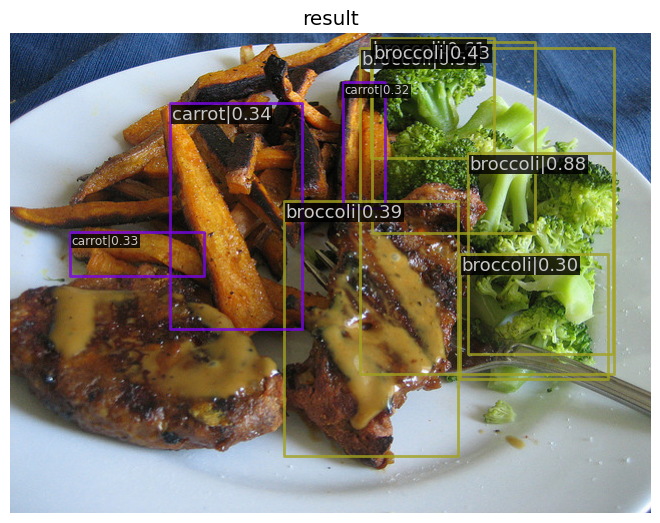

In [13]:
# from mmdet.apis import inference_detector

img = '/home/anna/MFTI/data/COCO/test2017/000000000161.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [ ]:
imshow_det_bboxes